In [37]:
# -*- coding: utf-8 -*-
"""Cointegration based Backtest.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1vlEa6KdkPY_GF8APWNPFv_eaUMdGZumc

#Cointegration based Pairs Trading Strategy: OVERVIEW
Overview of the project
1. OLS Regression: Conduct an Ordinary Least Squares (OLS) regression, where the first difference of the series is regressed against its value and any differences. This aims to understand the relationship between the changes in the series and its past values.

2. Augmented Dickey-Fuller: Implement the Augmented Dickey-Fuller (ADF) test to determine the test statistic. This measures the importance of the level in explaining the changes in the series.

3. Trading Bounds Analysis: Determine the upper and lower trading bounds from the residuals, essential for developing a pairs trading strategy.
"""

import yfinance as yf
import pandas as pd
import time

# Trending sector/ Stocks: Magnificent 7 + AI/Semiconductor-focused stocks + Crypto
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "TSLA", "META", "AVGO", "AMD", "INTC", "QCOM",
 "MU", "SMCI", "CRCL", "MSTR", "CRWV", "NBIS", "ORCL", "PLTR", "HOOD", "COIN",
 "BE", "HSAI", "CRDO", "PSIX", "DAVE", "MDB", "PANW", "OKLO", "APP"]

interval = "5m"
period = "60d"

historical_prices = {}

for ticker in tickers:
    try:
        data = yf.Ticker(ticker).history(interval=interval, period=period)
        if not data.empty:
            historical_prices[ticker] = data["Close"]
        else:
            print(f"No data for {ticker}")
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
    time.sleep(0.1)

# Combine into single DataFrame
historical_prices = pd.DataFrame(historical_prices)
historical_prices = historical_prices.ffill()

# Show first few rows
historical_prices.head()

,AAPL,MSFT,GOOGL,AMZN,NVDA,TSLA,META,AVGO,AMD,INTC,...,COIN,BE,HSAI,CRDO,PSIX,DAVE,MDB,PANW,OKLO,APP
Datetime,,,,,,,,,,,,,,,,,,,,,
2025-06-26 09:30:00-04:00,201.585007,494.500000,171.223999,212.909805,155.110001,329.599915,713.972229,265.730011,143.809998,22.434999,...,363.029999,21.703600,19.410000,92.120003,62.494999,227.980103,203.712494,205.869995,56.180000,330.790009
2025-06-26 09:35:00-04:00,200.089996,494.690002,170.910004,212.730301,154.949997,326.331512,712.729980,265.579987,143.104996,22.430000,...,362.570007,21.680000,19.389999,93.370003,63.270000,235.044998,204.770004,205.270004,57.205002,333.459991
2025-06-26 09:40:00-04:00,200.020004,494.350006,171.089996,212.969894,154.954803,328.054993,712.889893,265.265808,142.860001,22.333000,...,368.265015,21.850000,19.422899,93.163002,64.190002,236.035004,204.350006,205.240005,57.099998,333.830597
2025-06-26 09:45:00-04:00,200.044998,494.364990,170.100006,212.315002,154.626907,327.734985,712.315002,265.554993,142.104996,22.275000,...,368.279999,21.870001,19.260000,93.500000,64.169800,234.744995,204.820007,204.910004,56.619999,333.164795
2025-06-26 09:50:00-04:00,200.776596,494.760010,170.339996,212.546906,154.798996,326.932495,713.880005,266.730011,142.475006,22.290001,...,366.559204,21.730000,18.990000,93.194397,64.049599,234.076706,204.160004,204.559998,56.527500,334.984985


In [38]:
historical_prices.index.max()

Timestamp('2025-09-19 15:55:00-0400', tz='America/New_York')

In [39]:
historical_prices.describe()

,AAPL,MSFT,GOOGL,AMZN,NVDA,TSLA,META,AVGO,AMD,INTC,...,COIN,BE,HSAI,CRDO,PSIX,DAVE,MDB,PANW,OKLO,APP
count,4644.000000,4644.000000,4644.000000,4644.000000,4644.000000,4644.000000,4644.000000,4644.000000,4644.000000,4644.000000,...,4644.000000,4644.000000,4644.000000,4644.000000,4644.000000,4644.000000,4644.000000,4644.000000,4644.000000,4644.000000
mean,221.322832,509.521792,203.135143,226.544871,172.682929,335.130268,743.610064,301.751752,160.515276,23.181407,...,341.918414,41.752445,23.750940,117.536930,85.036639,216.435396,247.906466,190.621208,71.463127,430.496771
std,12.205021,10.606627,23.065653,5.658145,7.779755,31.122841,25.504633,26.923886,12.426146,2.165309,...,36.901877,15.948213,3.015262,23.195265,10.142256,24.355165,48.086220,11.481155,13.197294,84.942627
min,199.687302,489.832489,170.100006,211.651596,151.710098,289.630005,692.695007,262.859985,133.670593,19.014999,...,292.119995,21.575001,18.010000,84.440002,61.915001,178.235001,199.804993,165.410004,50.299999,326.015808
25%,210.728748,501.857513,184.807400,222.369995,168.973755,316.555000,719.515015,281.153748,154.224998,22.070000,...,310.449997,25.933750,21.363750,98.830002,79.897501,198.089996,210.287849,182.884373,63.810076,358.542511
50%,223.452499,507.767502,198.332504,227.334999,174.355003,329.096298,747.945007,296.690002,160.460251,23.317500,...,324.754990,38.192499,22.809999,114.250000,86.692497,211.955200,223.717499,193.080002,71.752499,412.465012
75%,231.542496,513.370499,210.771248,231.229996,178.570007,343.938248,765.128769,307.071251,170.242504,24.445000,...,376.769989,51.362500,26.250000,123.742973,91.191877,229.594997,310.177551,200.036251,76.230003,476.535004
max,246.126205,544.664978,255.970001,238.804993,183.750000,431.519989,795.520020,372.375000,186.479996,32.294998,...,444.029999,85.120399,30.139999,176.449997,114.610001,283.890015,344.444000,209.949905,135.410004,649.969971


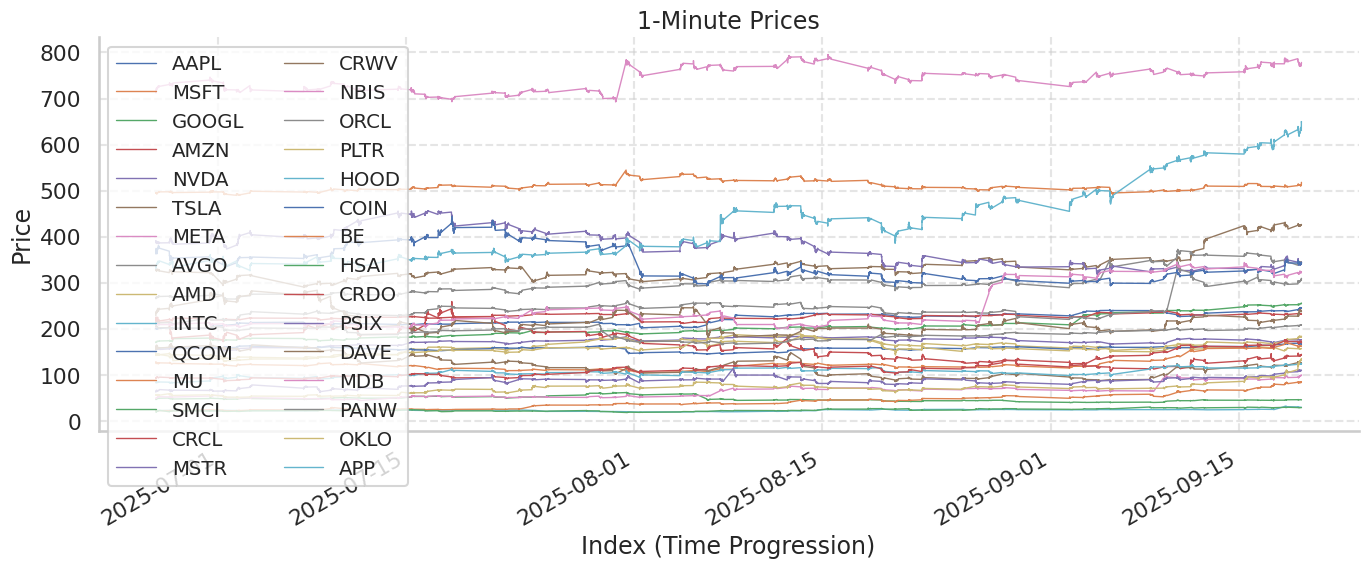

In [40]:
import matplotlib.pyplot as plt
import pandas as pd

# Create integer-based index for plotting
plot_data = historical_prices.copy()
#plot_data.index = range(len(plot_data))

# Plot using integer index
plt.figure(figsize=(14, 6))
plot_data.plot(ax=plt.gca(), linewidth=1)

plt.title("1-Minute Prices")
plt.xlabel("Index (Time Progression)")
plt.ylabel("Price")
plt.grid(linestyle='--', alpha=0.5)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.legend(loc='upper left', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

/tmp/ipython-input-2083494309.py:20: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = linkage(dist, method="average")


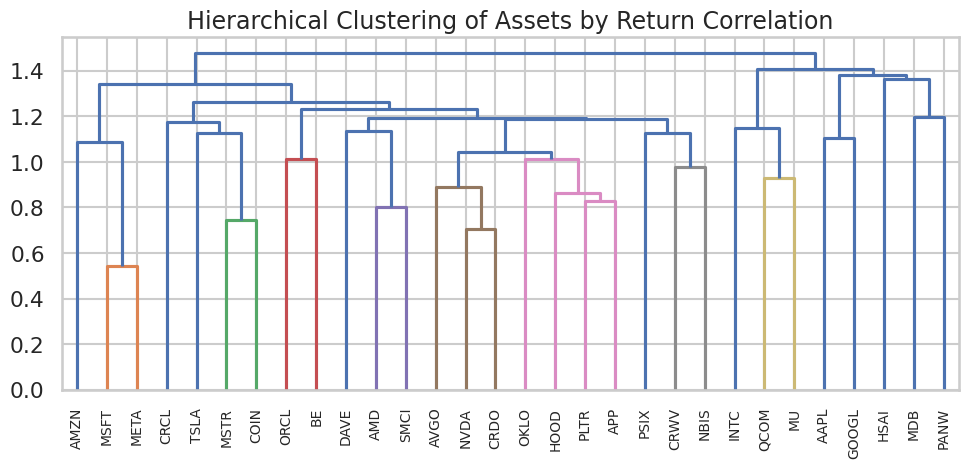

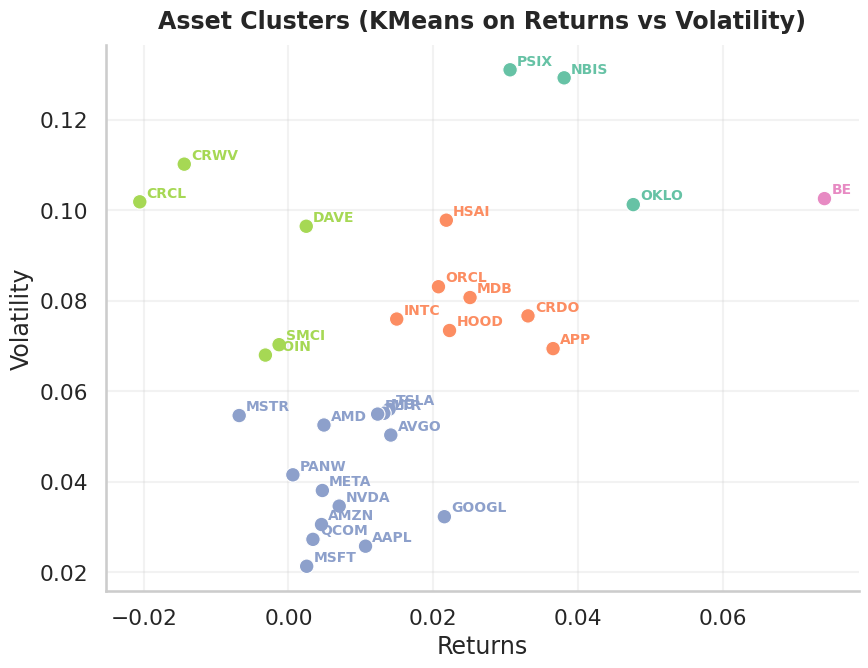

In [41]:


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.manifold import MDS
from sklearn.cluster import KMeans

# =========================
# 1) Compute log returns
# =========================
data = historical_prices.copy()
data.index = pd.to_datetime(data.index)

returns = np.log(data / data.shift(1)).dropna()
corr = returns.corr()
dist = 1 - corr  # distance = 1 - correlation

link = linkage(dist, method="average")

plt.figure(figsize=(10, 5))
dendrogram(link, labels=corr.columns, leaf_rotation=90)
plt.title("Hierarchical Clustering of Assets by Return Correlation")
plt.tight_layout()
plt.show()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Copy historical prices
data = historical_prices.copy()
data.index = pd.to_datetime(data.index)

# Compute log returns
returns = np.log(data / data.shift(1)).dropna()

# Annualized mean returns and volatility
mean_returns = returns.mean() * 252
volatility = returns.std() * np.sqrt(252)

# Create a DataFrame with features for clustering
features = pd.DataFrame({
    'Mean_Returns': mean_returns,
    'Volatility': volatility
})

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# KMeans clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(scaled_features)

# Plot clusters
palette = sns.color_palette("Set2", n_colors=n_clusters)
plt.figure(figsize=(9, 7))

sns.scatterplot(
    x=features['Mean_Returns'],
    y=features['Volatility'],
    hue=labels,
    palette=palette,
    s=110,
    legend=False
)

# Offsets for annotation (scales with data range)
dx = 0.01 * (features['Mean_Returns'].max() - features['Mean_Returns'].min() or 1)
dy = 0.01 * (features['Volatility'].max() - features['Volatility'].min() or 1)

# Annotate asset names (use .iloc for positional access)
for i, asset in enumerate(features.index):
    x = features['Mean_Returns'].iloc[i]
    y = features['Volatility'].iloc[i]
    plt.text(x + dx, y + dy, asset, fontsize=10, weight="bold", color=palette[labels[i]])

# Final styling
plt.title("Asset Clusters (KMeans on Returns vs Volatility)", pad=12, weight="bold")
plt.xlabel("Returns")
plt.ylabel("Volatility")
plt.grid(True, alpha=0.25)
sns.despine()
plt.tight_layout()
plt.show()

In [42]:
"""### Testing out a single pair OLS fit on Nvidia and Intel"""

import statsmodels.api as sm

y = historical_prices["NVDA"]
X = historical_prices["INTC"]
X = sm.add_constant(X)

#Fit OLS
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   NVDA   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.802
Date:                Mon, 22 Sep 2025   Prob (F-statistic):             0.0512
Time:                        03:52:01   Log-Likelihood:                -16114.
No. Observations:                4644   AIC:                         3.223e+04
Df Residuals:                    4642   BIC:                         3.225e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        175.0656      1.227    142.646      0.000     172.660     177.472
INTC          -0.1028      0.053     -1.950      0.051      -0.206       0.001
==============================================================================
Omnibus:                      416.043   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              524.359
Skew:                          -0.813   Prob(JB):                    1.37e-114
Kurtosis:                       2.746   Cond. No.                         251.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Using the statsmodels library, we’ve performed an OLS regression to understand the linear relationship between the assets. The following are the key results:

1. **Intercept (Alpha)**:
* This value represents the expected value of Asset 1 when Asset 2 is zero. It’s the point where the regression line crosses the Y-axis.

2. **Slope (Beta)**:
* This coefficient represents the change in Asset 1 for a unit change in Asset 2.

3. **R-squared**:
* This metric provides the proportion of the variance in the dependent variable (Asset 1) that’s predictable from the independent variable (Asset 2). An R-squared of 0.333 suggests that approximately 33.3% of the variability in Asset 1 can be explained by Asset 2.

4. **Durbin-Watson**:
* This test statistic tests for the presence of autocorrelation in the residuals. A value close to 2 suggests no autocorrelation, while a value that is far from 2, indicating possible autocorrelation.

5. **Condition Number**:
* A high value suggests potential multicollinearity issues or other numerical problems.

In [43]:
### Implement OLS Regression for the other pairs.
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import itertools
import numpy as np

results = []

for asset1, asset2 in itertools.combinations(historical_prices.columns, 2):
    y = historical_prices[asset1].fillna(0)
    X = historical_prices[[asset2]].fillna(0)
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()
    residuals = model.resid

    pair_key = f"{asset1}-{asset2}"
    results.append({
        'pair': pair_key,
        'alpha': model.params['const'],
        'beta': model.params[asset2],
        'r_squared': model.rsquared,
        'durbin_watson': durbin_watson(residuals),
        'condition_number': model.condition_number
    })

# Convert to DataFrame for inspection
results_df = pd.DataFrame(results)

results_df.sort_values(by='r_squared', ascending=False)

,pair,alpha,beta,r_squared,durbin_watson,condition_number
419,CRDO-APP,3.021677,0.266007,0.948942,0.012924,2266.975594
83,GOOGL-APP,89.760026,0.263359,0.940623,0.011027,2266.975594
77,GOOGL-CRDO,89.999744,0.962552,0.936948,0.011968,618.891066
75,GOOGL-BE,144.989346,1.392632,0.927183,0.007288,125.320962
406,BE-APP,-35.996277,0.180602,0.925282,0.007865,2266.975594
...,...,...,...,...,...,...
221,AMD-MDB,159.326446,0.004795,0.000344,0.001846,1326.309978
117,NVDA-SMCI,173.363880,-0.014203,0.000097,0.002348,432.406777
32,MSFT-TSLA,508.450464,0.003197,0.000088,0.004284,3640.217414
100,AMZN-COIN,226.742423,-0.000578,0.000014,0.005916,3205.348672


## Spread and Its Significance in Pairs Trading

In pairs trading, the spread is a pivotal concept. It quantifies the deviation of the relationship between two assets from their historical mean. When the spread substantially diverges from this mean, trading opportunities might emerge.


The spread is calculated as:

$$
\text{Spread} = X - (\alpha + \beta \times Y)
$$

Here:
* X = Asset 1
* Y = Asset 2
* α represents the intercept from our OLS regression.
* β denotes the slope or hedge ratio from our OLS regression.


The spread, in essence, captures the residuals of our regression model. It signifies the difference between the actual price of Asset 1 and its predicted value based on the price of Asset 2.

## Visualising Residuals for Spread Trading

It’s essential to compute the residuals to be used for trading. These residuals represent the deviations between the observed price of Asset 1 and its predicted value based with the Asset 2 prices.

Residuals are an integral part of pairs trading. They encapsulate the temporary mispricings or deviations from the established relationship between the two assets, which are the trading opportunities we aim to exploit."""


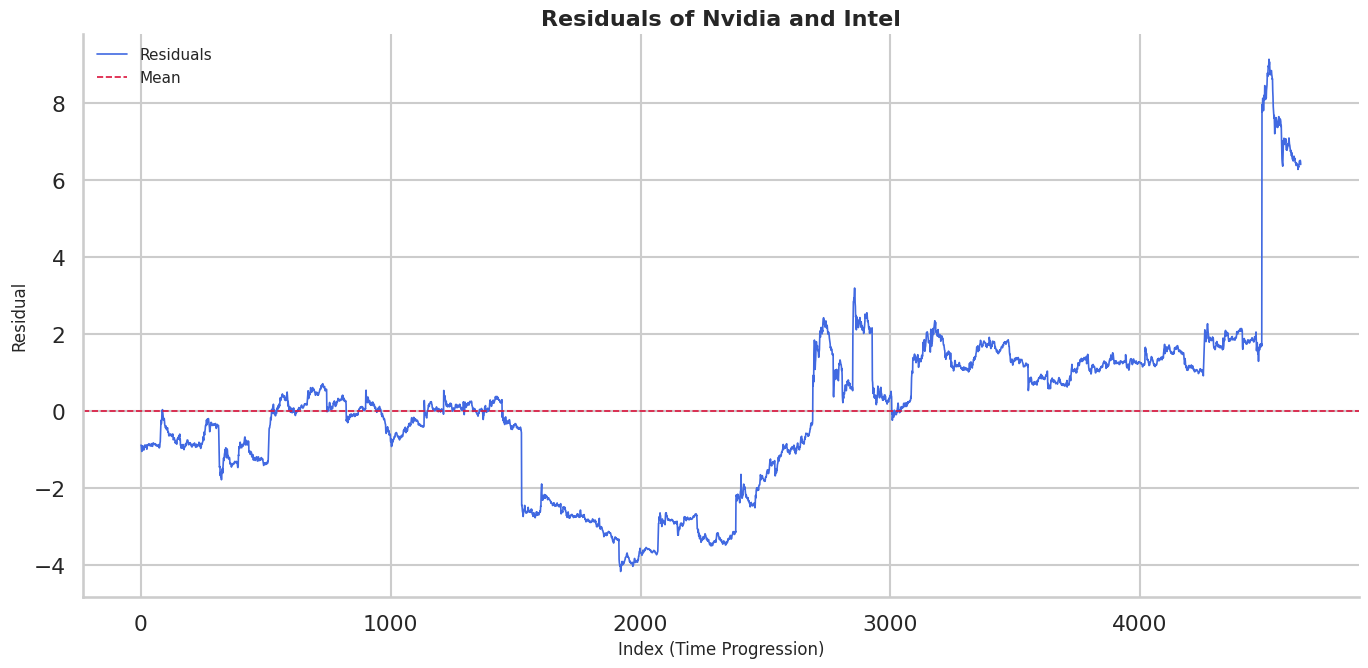

In [44]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Calculate residuals
X_const = sm.add_constant(historical_prices["NVDA"])
model = sm.OLS(historical_prices["INTC"], X_const).fit()
residuals = model.resid

# Create x-axis based on integer index
x_vals = range(len(residuals))

# Plot residuals with enhanced styling
plt.figure(figsize=(14, 7))
plt.plot(x_vals, residuals, label='Residuals', color='royalblue', linewidth=1.2)
plt.axhline(residuals.mean(), color='crimson', linestyle='--', linewidth=1.2, label='Mean')

plt.title('Residuals of Nvidia and Intel', fontsize=16, weight='bold')
plt.xlabel('Index (Time Progression)', fontsize=12)
plt.ylabel('Residual', fontsize=12)
plt.legend(frameon=False, fontsize=11)
plt.gca().spines[['top', 'right']].set_visible(False)  # Hide top and right borders
plt.tight_layout()
plt.show()

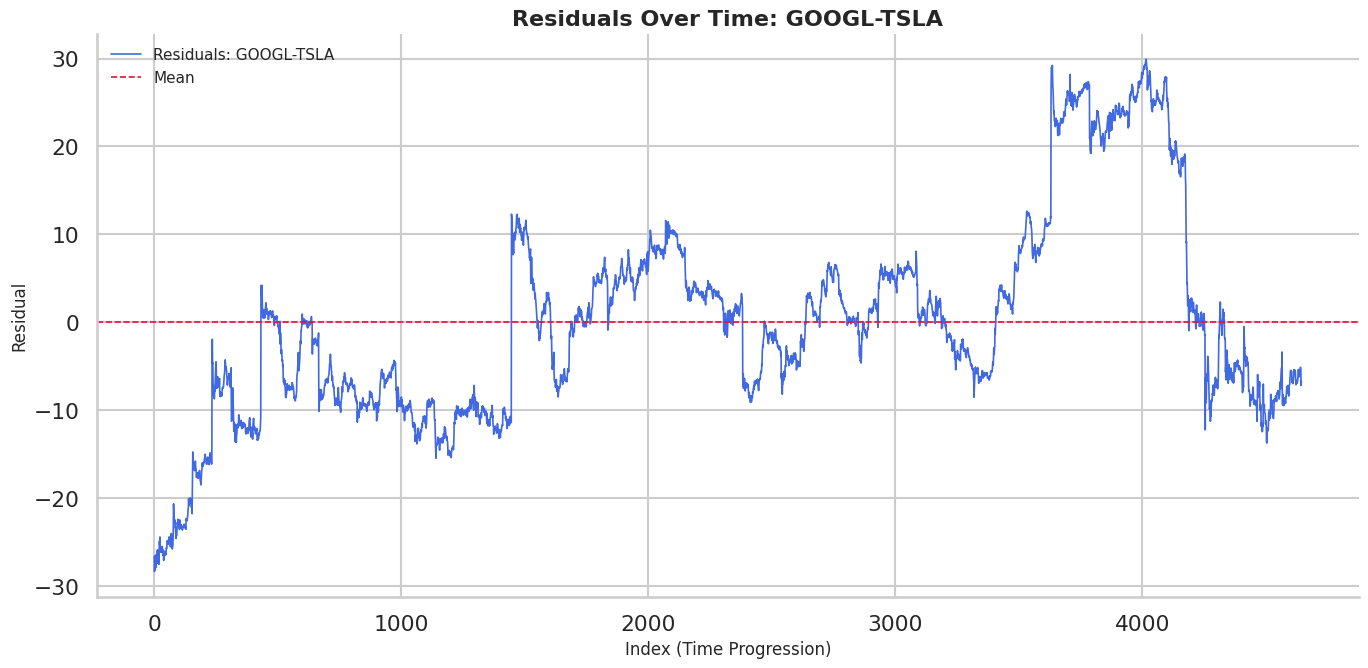

In [45]:
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm

residuals_dict = {}

# Compute residuals for each pair
for asset1, asset2 in itertools.combinations(historical_prices.columns, 2):
    X = sm.add_constant(historical_prices[asset2]).fillna(0)
    y = historical_prices[asset1].fillna(0)

    model = sm.OLS(y, X).fit()
    residuals = model.resid

    pair_key = f"{asset1}-{asset2}"
    residuals_dict[pair_key] = residuals

# Plot the residuals for an example pair
example_pair = "GOOGL-TSLA"
if example_pair in residuals_dict:
    residuals = residuals_dict[example_pair]
    x_vals = range(len(residuals))

    plt.figure(figsize=(14, 7))
    plt.plot(x_vals, residuals, label=f'Residuals: {example_pair}', color='royalblue', linewidth=1.2)
    plt.axhline(residuals.mean(), color='crimson', linestyle='--', linewidth=1.2, label='Mean')
    plt.title(f'Residuals Over Time: {example_pair}', fontsize=16, weight='bold')
    plt.xlabel('Index (Time Progression)', fontsize=12)
    plt.ylabel('Residual', fontsize=12)
    plt.legend(frameon=False, fontsize=11)
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.tight_layout()
    plt.show()
else:
    print(f"Pair '{example_pair}' not found in residuals.")

## Augmented Dickey-Fuller Test

The Augmented Dickey-Fuller (ADF) test is a prominent unit root test used to diagnose the stationarity of a given time series. A time series is deemed stationary if its statistical attributes (such as mean and variance) do not alter over time. For our pairs trading strategy, ascertaining stationarity is pivotal, as it ensures that the spread between the pairs is mean-reverting, allowing for potential arbitrage opportunities.

#### Implementation Steps:
1. **OLS Regression**:
* An Ordinary Least Squares (OLS) regression was conducted where the first difference of the series was regressed against its value and any differences. The purpose is to capture the relationship between the changes in the series and its past values.

2. **Test Statistic Calculation**:
* The ADF test statistic was derived as the quotient of the coefficient of the level of the series and its standard error. This statistic gauges the significance of the level in explaining the changes in the series.

3. **Comparison with Critical Values**:
* To make an inference regarding stationarity, the computed test statistic is contrasted against predefined critical values. If the statistic is less than the critical value (often at 1%, 5%, or 10% significance levels), the null hypothesis of a unit root (implying non-stationarity) is rejected, signaling that the series is stationary.

p-value < 0.05 → Residuals are stationary → Cointegrated

p-value > 0.05 → Residuals are not stationary → Not cointegrated

In [46]:
residuals = residuals_dict["GOOGL-TSLA"]

from statsmodels.tsa.stattools import adfuller
def adf_test(y):
    y = pd.Series(y)

    # Using statsmodels to get the results
    adf_result = adfuller(y, maxlag=0)
    pvalue = adf_result[1]
    critical_values = adf_result[4]

    print(f"ADF Statistic (statsmodels): {adf_result[0]}")
    print(f"p-value: {pvalue:.10f}")
    for key, value in critical_values.items():
        print(f"Critical Value ({key}): {value}")

adf_test(residuals)

ADF Statistic (statsmodels): -2.960135907165653
p-value: 0.0387886557
Critical Value (1%): -3.431759200736512
Critical Value (5%): -2.862162703805248
Critical Value (10%): -2.567101467800295


In [47]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

# Use residuals_dict from previous block and calculate ADF statistics on each
adf_results = []

for pair_key, residuals in residuals_dict.items():
    residuals = pd.Series(residuals).dropna()  # Ensure no NaNs
    adf_result = adfuller(residuals, maxlag=0)

    adf_results.append({
            'pair': pair_key,
            'adf_stat': adf_result[0],
            'pvalue': adf_result[1],
            'crit_1%': adf_result[4]['1%'],
            'crit_5%': adf_result[4]['5%'],
            'crit_10%': adf_result[4]['10%']
        })

# Convert to DataFrame
adf_df = pd.DataFrame(adf_results)

#sort by p-value (most stationary first)
adf_df = adf_df.sort_values(by='pvalue')
adf_df

,pair,adf_stat,pvalue,crit_1%,crit_5%,crit_10%
384,HOOD-PSIX,-4.703131,0.000083,-3.431759,-2.862163,-2.567101
356,NBIS-APP,-4.554099,0.000157,-3.431759,-2.862163,-2.567101
423,PSIX-OKLO,-4.339185,0.000380,-3.431759,-2.862163,-2.567101
77,GOOGL-CRDO,-3.838812,0.002534,-3.431759,-2.862163,-2.567101
299,CRCL-MSTR,-3.832847,0.002589,-3.431759,-2.862163,-2.567101
...,...,...,...,...,...,...
267,MU-CRWV,0.683218,0.989497,-3.431759,-2.862163,-2.567101
434,OKLO-APP,0.785596,0.991400,-3.431759,-2.862163,-2.567101
62,GOOGL-AMD,0.894025,0.993012,-3.431759,-2.862163,-2.567101
402,BE-DAVE,1.462298,0.997380,-3.431759,-2.862163,-2.567101


In [48]:
df = results_df.merge(adf_df, on='pair', how='inner')

df.head(5)

,pair,alpha,beta,r_squared,durbin_watson,condition_number,adf_stat,pvalue,crit_1%,crit_5%,crit_10%
0,AAPL-MSFT,209.491624,0.023220,0.000407,0.000847,24489.773946,-0.671050,0.854106,-3.431759,-2.862163,-2.567101
1,AAPL-GOOGL,128.940561,0.454782,0.738689,0.002968,1812.274040,-1.949832,0.308994,-3.431759,-2.862163,-2.567101
2,AAPL-AMZN,-85.514097,1.354420,0.394256,0.004653,9077.377826,-1.977449,0.296548,-3.431759,-2.862163,-2.567101
3,AAPL-NVDA,95.082005,0.731056,0.217148,0.001541,3841.267512,-0.694423,0.848189,-3.431759,-2.862163,-2.567101
4,AAPL-TSLA,125.330741,0.286432,0.533488,0.002942,3640.217414,-2.482790,0.119718,-3.431759,-2.862163,-2.567101


## Trading Bounds Analysis

Pairs trading is predicated on the belief that if two co-integrated securities drift apart in terms of price, they will eventually revert back to a mean. The strategy thus revolves around identifying deviations from this mean and capitalizing on the expected mean reversion.

1. **Long Signal**:

This arises when the spread (or the residuals) dips below a predetermined lower threshold. A low spread indicates that, relative to its counterpart, the primary asset (as per our regression) is undervalued. In response, we should:

* Long the primary asset (believing its price will rise).
* Short the secondary asset (anticipating a price drop).

$$
\text{Spread}_t < \text{Lower Bound} \Rightarrow \text{Long Asset 1, Short Asset 2}
$$

2. **Short Signal**:

This is activated when the spread exceeds a predetermined upper threshold. A high spread signifies that the primary asset is overpriced relative to the secondary asset. Consequently, we should:

* Short the primary asset (anticipating its price will fall).
* Long the secondary asset (believing its price will ascend).

$$
\text{Spread}_t > \text{Upper Bound} \Rightarrow \text{Short Asset 1, Long Asset 2}
$$


3. **Exit Signal (Neutralize):**

This signal prompts us to close out any positions and return to a neutral stance. It’s initiated when the spread converges back towards its mean, hinting at the assets reverting to their equilibrium relationship. This is our cue to capitalize on the positions we’ve taken based on the long/short signals and secure our gains.

$$
\text{Lower Bound} \leq \text{Spread}_t \leq \text{Upper Bound} \Rightarrow \text{Exit Positions}
$$



### Fitting a naive threshold (1 sigma) spread bounds for entry and exit

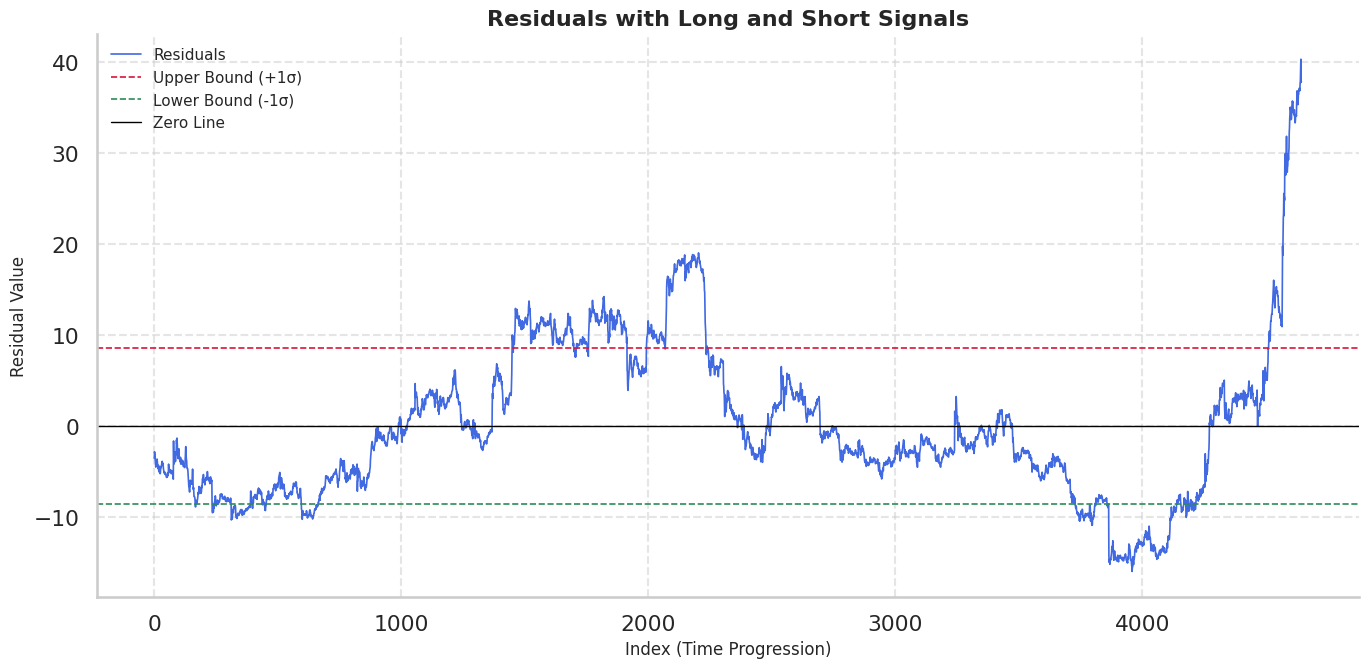

In [49]:


import pandas as pd
import matplotlib.pyplot as plt

def generate_signals(residuals, Z, price_data_index, show_graph=True):
    mu_e = residuals.mean()
    sigma_eq = residuals.std()
    upper_bound = mu_e + Z * sigma_eq
    lower_bound = mu_e - Z * sigma_eq

    # Ensure residuals is a Series
    if not isinstance(residuals, pd.Series):
        residuals_series = pd.Series(residuals, index=price_data_index)
    else:
        residuals_series = residuals

    # Generate signals
    signals = pd.Series(index=residuals_series.index, dtype='float64')
    signals[residuals_series > upper_bound] = -1  # Short
    signals[residuals_series < lower_bound] = 1   # Long
    signals = signals.fillna(0)

    if show_graph:
        x_vals = range(len(residuals_series))

        plt.figure(figsize=(14, 7))
        plt.plot(x_vals, residuals_series.values, label='Residuals', color='royalblue', linewidth=1.2)
        plt.axhline(upper_bound, color='crimson', linestyle='--', linewidth=1.2, label=f'Upper Bound (+{Z}σ)')
        plt.axhline(lower_bound, color='seagreen', linestyle='--', linewidth=1.2, label=f'Lower Bound (-{Z}σ)')
        plt.axhline(0, color='black', linestyle='-', linewidth=1.0, label='Zero Line')

        plt.title('Residuals with Long and Short Signals', fontsize=16, weight='bold')
        plt.xlabel('Index (Time Progression)', fontsize=12)
        plt.ylabel('Residual Value', fontsize=12)
        plt.legend(frameon=False, fontsize=11)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.gca().spines[['top', 'right']].set_visible(False)
        plt.tight_layout()
        plt.show()

    return upper_bound, lower_bound, residuals_series



upper_bound, lower_bound, residuals_series = generate_signals(residuals, 1, historical_prices.index[1:-1])

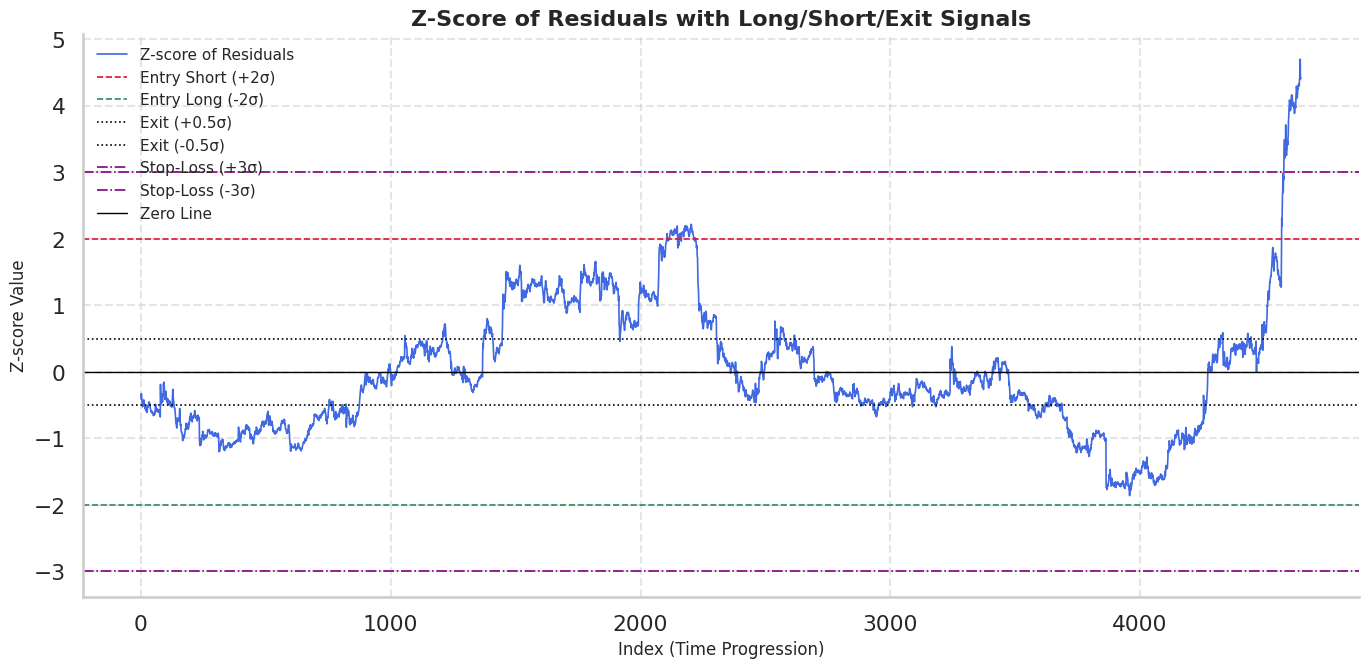

In [50]:


# Update the generate_signals function
import pandas as pd
import matplotlib.pyplot as plt

def generate_signals(residuals, entry_z=1.0, exit_z=0.5, stop_z=1.5, price_data_index=None, show_graph=True):
    mu = residuals.mean()
    sigma = residuals.std()

    # Ensure residuals is a Series
    if not isinstance(residuals, pd.Series):
        residuals_series = pd.Series(residuals, index=price_data_index)
    else:
        residuals_series = residuals

    # Compute Z-scores
    zscores = (residuals_series - mu) / sigma
    signals = pd.Series(index=zscores.index, dtype='int')

    # Trading logic
    signals[zscores > entry_z] = -1   # Short entry
    signals[zscores < -entry_z] = 1   # Long entry
    signals[zscores.abs() < exit_z] = 0  # Exit condition
    signals[zscores.abs() > stop_z] = 0  # Stop-loss condition
    signals = signals.fillna(0)

    if show_graph:
        x_vals = range(len(zscores))
        plt.figure(figsize=(14, 7))
        plt.plot(x_vals, zscores.values, label='Z-score of Residuals', color='royalblue', linewidth=1.2)
        plt.axhline(entry_z, color='crimson', linestyle='--', linewidth=1.2, label=f'Entry Short (+{entry_z}σ)')
        plt.axhline(-entry_z, color='seagreen', linestyle='--', linewidth=1.2, label=f'Entry Long (-{entry_z}σ)')
        plt.axhline(exit_z, color='black', linestyle=':', linewidth=1.2, label=f'Exit (+{exit_z}σ)')
        plt.axhline(-exit_z, color='black', linestyle=':', linewidth=1.2, label=f'Exit (-{exit_z}σ)')
        plt.axhline(stop_z, color='purple', linestyle='-.', linewidth=1.2, label=f'Stop-Loss (+{stop_z}σ)')
        plt.axhline(-stop_z, color='purple', linestyle='-.', linewidth=1.2, label=f'Stop-Loss (-{stop_z}σ)')
        plt.axhline(0, color='black', linestyle='-', linewidth=1.0, label='Zero Line')

        plt.title('Z-Score of Residuals with Long/Short/Exit Signals', fontsize=16, weight='bold')
        plt.xlabel('Index (Time Progression)', fontsize=12)
        plt.ylabel('Z-score Value', fontsize=12)
        plt.legend(frameon=False, fontsize=11)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.gca().spines[['top', 'right']].set_visible(False)
        plt.tight_layout()
        plt.show()

    return signals, zscores

signals, zscores = generate_signals(residuals, entry_z=2, exit_z=0.5, stop_z = 3, price_data_index=historical_prices.index)

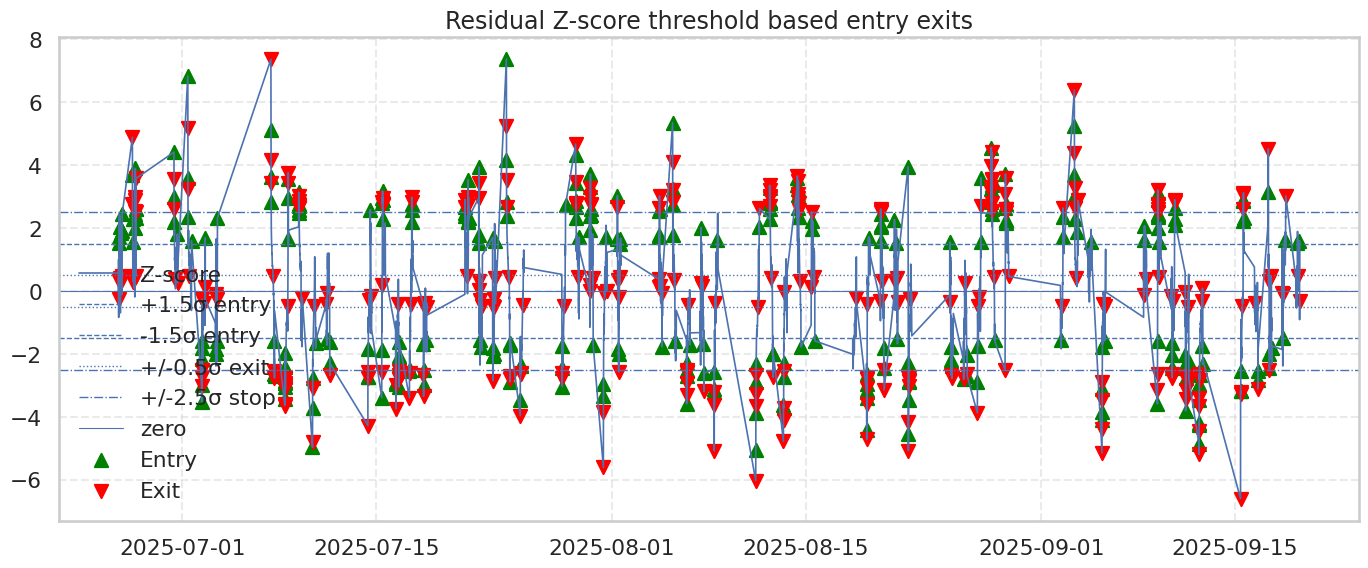

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count

def generate_signals(
    residuals: pd.Series,
    entry_z: float = 1.0,
    exit_z: float = 0.5,
    stop_z: float = 1.5,
    window: int = 60,
    show_graph: bool = True
) -> tuple[pd.Series, pd.Series]:
    """
    Generate stateful trading signals from residuals using z-scores.

    This function calculates z-scores from a time series of residuals using either a rolling
    or expanding window, then generates trading signals based on z-score thresholds:
    - Enter a long position (+1) when z-score < -entry_z.
    - Enter a short position (-1) when z-score > entry_z.
    - Exit a position (0) when |z-score| <= exit_z or |z-score| >= stop_z.
    Optionally, it visualizes the z-scores with entry/exit points.

    Parameters
    ----------
    residuals : pd.Series
        Time series of residuals to analyze (e.g., from a statistical model).
    entry_z : float, optional
        Z-score threshold for entering a position (default: 1.0).
    exit_z : float, optional
        Z-score threshold for exiting a position (default: 0.5).
    stop_z : float, optional
        Z-score threshold for stopping a position (default: 1.5).
    window : int, optional
        Size of the rolling window for z-score calculation. If None or <= 1,
        an expanding window is used (default: 60).
    show_graph : bool, optional
        If True, display a plot of z-scores with entry/exit points (default: True).

    Returns
    -------
    signals : pd.Series
        Series of trading signals: +1 (long), -1 (short), 0 (flat).
    zscores : pd.Series
        Series of calculated z-scores.

    Notes
    -----
    - The function ensures numerical stability by handling division-by-zero cases in z-score
      calculations using a small epsilon value and forward-filling missing standard deviations.
    - The plot, if enabled, shows z-scores with thresholds and entry/exit points.
    """
    # Convert residuals to a pandas Series and ensure float type
    residuals = pd.Series(residuals).astype(float)

    # Calculate rolling or expanding mean and standard deviation for z-scores
    if window and window > 1:
        rolling_mu = residuals.rolling(window, min_periods=2).mean()
        rolling_sig = residuals.rolling(window, min_periods=2).std(ddof=0)
    else:
        rolling_mu = residuals.expanding(min_periods=2).mean()
        rolling_sig = residuals.expanding(min_periods=2).std(ddof=0)

    # Handle division-by-zero and missing values in standard deviation
    eps = 1e-12  # Small constant to avoid division-by-zero
    rolling_sig = (
        rolling_sig.ffill()  # Forward-fill missing values
        .fillna(rolling_sig.mean())  # Fill remaining NaNs with mean std
        .replace(0, np.nan)  # Replace zero std with NaN
        .fillna(eps)  # Replace NaNs with epsilon
    )

    # Calculate z-scores: (residuals - mean) / std
    zscores = ((residuals - rolling_mu) / rolling_sig).fillna(0.0)

    # Initialize stateful signals array
    sig = np.zeros(len(zscores), dtype="int8")
    last = 0  # Track current position: 0 (flat), 1 (long), -1 (short)

    # Generate stateful signals based on z-score thresholds
    for i, z in enumerate(zscores.values):
        if last == 0:  # Flat: check for entry conditions
            if z > entry_z:
                last = -1  # Enter short position
            elif z < -entry_z:
                last = 1   # Enter long position
        else:  # In a position: check for exit or stop conditions
            if abs(z) <= exit_z or abs(z) >= stop_z:
                last = 0  # Exit position
        sig[i] = last

    # Convert signals to a pandas Series
    signals = pd.Series(sig, index=zscores.index, dtype="int8")

    # Visualize z-scores and signals if requested
    if show_graph:
        x_vals = residuals.index
        plt.figure(figsize=(14, 6))
        plt.plot(x_vals, zscores.values, label="Z-score", linewidth=1.2)
        plt.axhline(entry_z, linestyle="--", linewidth=1.0, label=f"+{entry_z}σ entry")
        plt.axhline(-entry_z, linestyle="--", linewidth=1.0, label=f"-{entry_z}σ entry")
        plt.axhline(exit_z, linestyle=":", linewidth=1.0, label=f"+/-{exit_z}σ exit")
        plt.axhline(-exit_z, linestyle=":", linewidth=1.0)
        plt.axhline(stop_z, linestyle="-.", linewidth=1.0, label=f"+/-{stop_z}σ stop")
        plt.axhline(-stop_z, linestyle="-.", linewidth=1.0)
        plt.axhline(0, linestyle="-", linewidth=0.8, label="zero")

        # Identify entry and exit points for plotting
        prev = signals.shift(1).fillna(0).astype(int)
        entries_mask = (prev == 0) & (signals != 0)
        exits_mask = (prev != 0) & (signals == 0)
        plt.scatter(signals.index[entries_mask], zscores.loc[entries_mask], marker="^", s=90, label="Entry", color='green')
        plt.scatter(signals.index[exits_mask], zscores.loc[exits_mask], marker="v", s=90, label="Exit", color='red')

        plt.title("Residual Z-score threshold based entry exits")
        plt.legend(frameon=False)
        plt.grid(True, linestyle="--", alpha=0.4)
        plt.tight_layout()
        plt.show()

    return signals, zscores

pair = "GOOGL-TSLA"
residuals = residuals_dict[pair]
signals, zscores = generate_signals(residuals, entry_z=1.5, exit_z=0.5, stop_z = 2.5, window=60)

### Use distributions of residuals to dynamically set thesholds as characterstics of the residuals change.

In [52]:
###### Selected universe of pairs
df.sort_values(by="r_squared", ascending=False)

#Select universe based on R2 score

stockPairs = df[df["r_squared"]>0.5].reset_index().drop("index",axis=1)
stockPairs

,pair,alpha,beta,r_squared,durbin_watson,condition_number,adf_stat,pvalue,crit_1%,crit_5%,crit_10%
0,AAPL-GOOGL,128.940561,0.454782,0.738689,0.002968,1812.274040,-1.949832,0.308994,-3.431759,-2.862163,-2.567101
1,AAPL-TSLA,125.330741,0.286432,0.533488,0.002942,3640.217414,-2.482790,0.119718,-3.431759,-2.862163,-2.567101
2,AAPL-AVGO,119.226438,0.338346,0.557083,0.003480,3409.230589,-1.951473,0.308247,-3.431759,-2.862163,-2.567101
3,AAPL-SMCI,302.076105,-1.684287,0.552458,0.003856,432.406777,-2.202695,0.205269,-3.431759,-2.862163,-2.567101
4,AAPL-CRCL,268.538566,-0.288976,0.657376,0.004995,813.941360,-1.797884,0.381513,-3.431759,-2.862163,-2.567101
...,...,...,...,...,...,...,...,...,...,...,...
102,CRDO-OKLO,17.995862,1.392901,0.628075,0.002413,400.282455,-0.678935,0.852131,-3.431759,-2.862163,-2.567101
103,CRDO-APP,3.021677,0.266007,0.948942,0.012924,2266.975594,-3.793951,0.002970,-3.431759,-2.862163,-2.567101
104,PSIX-OKLO,38.619978,0.649519,0.714306,0.017764,400.282455,-4.339185,0.000380,-3.431759,-2.862163,-2.567101
105,MDB-APP,45.233837,0.470788,0.691609,0.002886,2266.975594,-1.689783,0.436384,-3.431759,-2.862163,-2.567101


In [53]:


"""### Backtesting on one pair"""

import numpy as np
import pandas as pd
from typing import Tuple, Union, Mapping

PriceStore = Union[pd.DataFrame, Mapping[str, pd.Series]]

def backtest_pair(
    signals: pd.Series,
    pair: str,
    prices: PriceStore,
    beta_table: Union[pd.Series, pd.DataFrame, None] = None,
    *,
    capital: float = 1000000.0,
    alloc_pct: float = 0.05,
    fee_rate: float = 0.0,
) -> Tuple[pd.Series, float, pd.Series, pd.Series]:
    """
    Market-neutral pair backtest with turnover fees.

    signals: Series of {-1,0,1} indexed by timestamp
    pair:    "AAA-BBB"
    prices:  dict/Mapping of symbol->Series, or a DataFrame with symbol columns
    beta_table: optional hedge ratio store:
        - pd.Series indexed by "AAA-BBB" with values beta
        - or DataFrame with either index=pair and col "beta", or columns ["pair","beta"]
    fee_rate: per-dollar traded (e.g., 10 bps => 0.001)
    """
    # ---- resolve price series ----
    a1, a2 = pair.split("-")
    if isinstance(prices, pd.DataFrame):
        if a1 not in prices.columns or a2 not in prices.columns:
            raise KeyError(f"Missing {a1}/{a2} in price DataFrame.")
        px1, px2 = prices[a1].copy(), prices[a2].copy()
    else:
        try:
            px1, px2 = prices[a1].copy(), prices[a2].copy()
        except KeyError as e:
            raise KeyError(f"Missing symbol in prices: {e}")

    # common timeline
    common = signals.index.intersection(px1.index).intersection(px2.index)
    if len(common) < 2:
        raise ValueError("Not enough overlapping timestamps to backtest.")
    signals = signals.reindex(common, fill_value=0).astype("int8")
    px1 = px1.reindex(common).ffill()
    px2 = px2.reindex(common).ffill()

    # ---- hedge ratio β ----
    beta = 1.0
    if beta_table is not None:
        try:
            if isinstance(beta_table, pd.Series):
                if pair in beta_table.index and np.isfinite(beta_table.loc[pair]):
                    beta = float(beta_table.loc[pair])
            elif isinstance(beta_table, pd.DataFrame):
                if "beta" in beta_table.columns and pair in beta_table.index:
                    v = beta_table.at[pair, "beta"]
                    if np.isfinite(v): beta = float(v)
                elif set(["pair","beta"]).issubset(beta_table.columns):
                    row = beta_table.loc[beta_table["pair"] == pair]
                    if not row.empty and np.isfinite(row["beta"].iloc[0]):
                        beta = float(row["beta"].iloc[0])
        except Exception:
            beta = 1.0  # safe fallback
    beta_series = pd.Series(beta, index=common)

    # ---- state ----
    shares1      = pd.Series(0.0, index=common)
    shares2      = pd.Series(0.0, index=common)
    daily_pnl    = pd.Series(0.0, index=common)
    equity_curve = pd.Series(capital, index=common)

    # ---- main loop ----
    for t in range(1, len(common)):
        idx, idx_prev = common[t], common[t-1]
        sig, sig_prev = signals.iat[t], signals.iat[t-1]
        b = beta_series.iat[t]

        delta_sh1 = delta_sh2 = 0.0

        # Close existing if going flat or flipping
        if sig == 0 or sig != sig_prev:
            delta_sh1 -= shares1.iat[t-1]
            delta_sh2 -= shares2.iat[t-1]

        # Open/adjust on entry
        if sig in (1, -1):
            curr_eq  = equity_curve.iat[t-1]
            notional = curr_eq * alloc_pct

            # split notional across legs to respect |beta|
            cash_leg2 = notional / (1.0 + abs(b))
            cash_leg1 = notional - cash_leg2

            new_sh1 =  sig * cash_leg1 / px1.loc[idx]
            new_sh2 = -sig * cash_leg2 / px2.loc[idx]

            delta_sh1 += new_sh1 - shares1.iat[t-1]
            delta_sh2 += new_sh2 - shares2.iat[t-1]

        # Fees on turnover (both legs)
        fee = fee_rate * (abs(delta_sh1) * px1.loc[idx] + abs(delta_sh2) * px2.loc[idx])

        # Update position
        shares1.iat[t] = shares1.iat[t-1] + delta_sh1
        shares2.iat[t] = shares2.iat[t-1] + delta_sh2

        # Mark-to-market P&L from prior holdings; fees charged on rebalance
        pnl = (shares1.iat[t-1] * (px1.loc[idx] - px1.loc[idx_prev]) +
               shares2.iat[t-1] * (px2.loc[idx] - px2.loc[idx_prev]) -
               fee)
        daily_pnl.iat[t]     = pnl
        equity_curve.iat[t]  = equity_curve.iat[t-1] + pnl

    # ---- metrics ----
    daily_ret = equity_curve.pct_change()

    # Active-day mask: exposure from t-1 -> t if we held anything at t-1
    held_prev = (shares1.shift(1).fillna(0).abs() + shares2.shift(1).fillna(0).abs()) > 0
    # Filter to valid returns (exclude first NaN) and count activity
    valid = daily_ret.notna()
    active_mask = valid & held_prev

    n_total  = int(valid.sum())
    n_active = int(active_mask.sum())

    if n_active == 0:
        sharpe = np.nan
    else:
        ret_active = daily_ret[active_mask]
        sd = ret_active.std(ddof=0)
        if sd == 0 or np.isnan(sd):
            sharpe = np.nan
        else:
            daily_sharpe = ret_active.mean() / sd
            # Activity-aware annualization: sqrt(252 * (active days / total days))
            scale = np.sqrt(252/60)
            sharpe = daily_sharpe * scale

    cum_pct_ret = (equity_curve / capital - 1.0) * 100.0
    return equity_curve, sharpe, cum_pct_ret, daily_pnl

equity, sr, pct, pnl = backtest_pair(signals,pair="GOOGL-TSLA",prices=historical_prices, beta_table=df, capital=1000000, alloc_pct=0.05, fee_rate=0.0000)
print("Sharpe (annualized):", sr)

/tmp/ipython-input-3542864663.py:115: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1000084.4930768303' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  equity_curve.iat[t]  = equity_curve.iat[t-1] + pnl


Sharpe (annualized): -0.02931358780373854



Summary:
                pnl
n_trades     304.00
win_rate       0.44
avg_pnl      -12.40
total_pnl -3,770.32


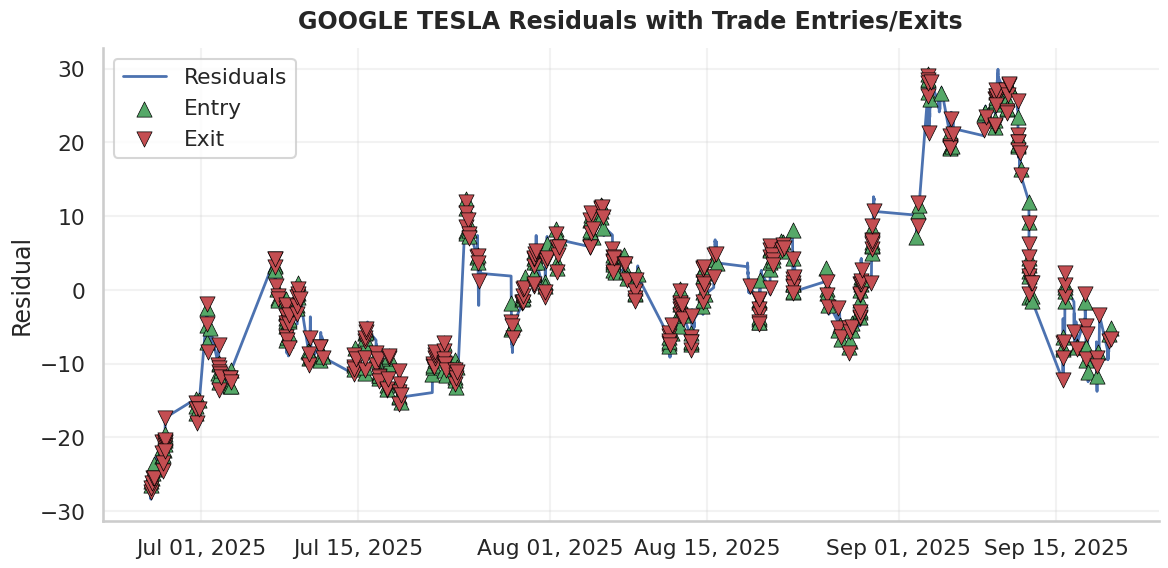

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def extract_trades(signals: pd.Series, daily_pnl: pd.Series) -> pd.DataFrame:
    """
    Build a trade ledger from entry/exit signals.
    - Treat flips (+1 -> -1 or -1 -> +1) as an exit followed by a new entry on the same bar.
    - Per-trade PnL is the sum of daily_pnl from the bar AFTER entry up to and including exit.
    """
    sig = signals.astype(int).copy()
    prev = sig.shift(1).fillna(0).astype(int)

    flip  = (sig != 0) & (prev != 0) & (sig != prev)
    entries_mask = ((prev == 0) & (sig != 0)) | flip
    exits_mask   = ((prev != 0) & (sig == 0)) | flip

    entries = list(sig.index[entries_mask])
    exits   = list(sig.index[exits_mask])

    # Align counts: if series starts in a position, ensure an entry first
    if len(entries) > 0 and len(exits) > 0:
        if exits[0] < entries[0]:
            exits = exits[1:]
    # If last entry has no exit, drop it (or handle open trade if you prefer)
    if len(entries) > len(exits):
        entries = entries[:len(exits)]

    rows = []
    for ent, ex in zip(entries, exits):
        side = int(sig.loc[ent])  # +1 or -1 at entry
        pnl_window = daily_pnl.loc[ent:ex]
        trade_pnl = pnl_window.iloc[1:].sum() if len(pnl_window) > 1 else 0.0
        rows.append({
            "entry_time": ent,
            "exit_time": ex,
            "side": side,            # +1: long first leg / short second; -1: opposite
            "bars": (signals.index.get_loc(ex) - signals.index.get_loc(ent)),
            "pnl": float(trade_pnl),
        })

    return pd.DataFrame(rows)


import seaborn as sns
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter, AutoDateLocator

# ---------- Style ----------
sns.set_theme(context="talk", style="whitegrid", font_scale=0.95)
# Palette for consistency
pal = sns.color_palette("deep")
ENTRY_COLOR = pal[2]   # greenish
EXIT_COLOR  = pal[3]   # reddish
LINE_COLOR1 = pal[0]
LINE_COLOR2 = pal[1]

def _fmt_dollars(x, pos):
    return f"${x:,.0f}"

def _annotate_last_point(ax, series, fmt="{:,.0f}", xytext=(6, 6)):
    if len(series) == 0:
        return
    x = series.index[-1]
    y = series.iloc[-1]
    ax.scatter([x], [y], s=80, zorder=5)
    ax.annotate(fmt.format(y), (x, y), xytext=xytext, textcoords="offset points",
                fontsize=10, weight="bold", bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="0.85"))

# ---------- Build ledger & summary ----------
ledger = extract_trades(signals, pnl)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

summary = ledger.agg(
    n_trades=("pnl", "size"),
    win_rate=("pnl", lambda s: (s > 0).mean() if len(s) else float("nan")),
    avg_pnl=("pnl", "mean"),
    total_pnl=("pnl", "sum")
)
print("\nSummary:")
print(summary)

# ---------- Inputs alignment ----------
if 'residuals' not in globals():
    raise NameError("Please provide a `residuals: pd.Series` aligned to `signals.index`.")
residuals = residuals.reindex(signals.index).astype(float)
cum_pnl = pnl.cumsum()

# Common date formatting
date_locator = AutoDateLocator()
date_formatter = DateFormatter("%b %d, %Y")

# ─────────────────────────────────────────────────────────────
# Plot 1: Residuals with entry/exit markers
# ─────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))
# base residual line
ax.plot(residuals.index, residuals.values, color=LINE_COLOR1, linewidth=2, label="Residuals")

# markers (guard against empty ledger)
if not ledger.empty:
    ax.scatter(
        ledger["entry_time"], residuals.loc[ledger["entry_time"]],
        marker="^", s=120, label="Entry", color=ENTRY_COLOR, edgecolor="black", linewidth=0.5, zorder=4
    )
    ax.scatter(
        ledger["exit_time"], residuals.loc[ledger["exit_time"]],
        marker="v", s=120, label="Exit", color=EXIT_COLOR, edgecolor="black", linewidth=0.5, zorder=4
    )

ax.set_title("GOOGLE TESLA Residuals with Trade Entries/Exits", pad=14, weight="bold")
ax.set_xlabel("")
ax.set_ylabel("Residual")
ax.xaxis.set_major_locator(date_locator)
ax.xaxis.set_major_formatter(date_formatter)
ax.grid(True, which="major", alpha=0.25)
ax.legend(frameon=True)
sns.despine(ax=ax, left=False, bottom=False)
plt.tight_layout()
plt.show()

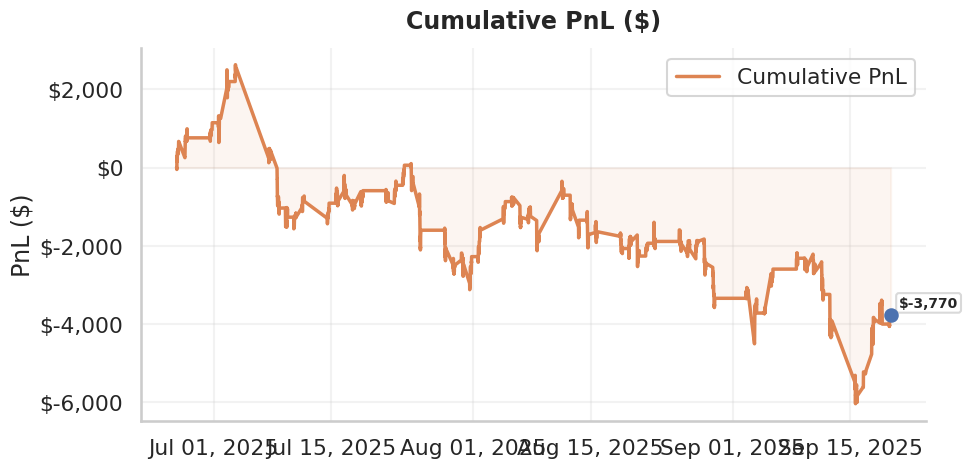

In [55]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(cum_pnl.index, cum_pnl.values, color=LINE_COLOR2, linewidth=2.5, label="Cumulative PnL")
ax.fill_between(cum_pnl.index, cum_pnl.values, alpha=0.08, color=LINE_COLOR2)

ax.set_title("Cumulative PnL ($)", pad=14, weight="bold")
ax.set_xlabel("")
ax.set_ylabel("PnL ($)")
ax.yaxis.set_major_formatter(FuncFormatter(_fmt_dollars))
ax.xaxis.set_major_locator(date_locator)
ax.xaxis.set_major_formatter(date_formatter)
ax.grid(True, which="major", alpha=0.25)
_annotate_last_point(ax, cum_pnl, fmt="${:,.0f}")
sns.despine(ax=ax, left=False, bottom=False)
ax.legend(frameon=True)
plt.tight_layout()
plt.show()

In [56]:


"""##Fitting the strategy to the portfolio"""

from itertools import product
from tqdm.auto import tqdm
import numpy as np
import pandas as pd

def _infer_periods_per_year(index: pd.DatetimeIndex) -> float:
    """
    Infer sampling frequency to annualize Sharpe.
    - If intraday (multiple points/day): ~252 * steps_per_day
    - If daily-ish: 252
    Fallback: 252
    """
    if not isinstance(index, pd.DatetimeIndex) or len(index) < 3:
        return 252.0
    # robust median step in seconds
    deltas_ns = np.diff(index.view("i8"))
    if len(deltas_ns) == 0:
        return 252.0
    dt_sec = float(np.median(deltas_ns)) / 1e9
    if dt_sec <= 0:
        return 252.0

    secs_per_day = 24 * 60 * 60
    steps_per_day = max(1.0, secs_per_day / dt_sec)
    return 252.0 * steps_per_day if steps_per_day > 2 else 252.0

# =========================
# Grid Optimizer with tqdm
# =========================
def optimize_thresholds_for_pairs(
    residuals_dict: dict,
    entry_z_values,
    exit_z_values,
    stop_z_values,
) -> pd.DataFrame:
    """
    Grid-search optimal (entry_z, exit_z, stop_z) for each pair in residuals_dict.
    Objective: max annualized Sharpe of strategy_returns = signals.shift(1) * spread_returns
    """
    all_results = []
    pair_iter = list(residuals_dict.items())

    for pair_key, residuals in tqdm(pair_iter, desc="Pairs", unit="pair"):
        residuals = pd.Series(residuals).dropna()
        if residuals.empty:
            all_results.append({"pair": pair_key, "entry_z": np.nan, "exit_z": np.nan,
                                "stop_z": np.nan, "sharpe": -np.inf})
            continue

        spread_returns = residuals.diff().shift(-1)  # next-step change on the spread
        spread_returns = spread_returns.reindex(residuals.index)

        best, best_sharpe = None, -np.inf
        grid = list(product(entry_z_values, exit_z_values, stop_z_values))

        for (entry_z, exit_z, stop_z) in tqdm(grid, leave=False, desc=f"{pair_key} grid", unit="cfg"):
            try:
                signals, _ = generate_signals(
                    residuals=residuals,
                    entry_z=entry_z,
                    exit_z=exit_z,
                    stop_z=stop_z,
                    show_graph=False
                )
                # one-bar delay (avoid lookahead)
                strategy_returns = signals.shift(1).reindex(spread_returns.index).fillna(0) * spread_returns
                strategy_returns = strategy_returns.dropna()

                vol = strategy_returns.std(ddof=0)
                if vol == 0 or np.isnan(vol):
                    ann_sharpe = -np.inf
                else:
                    pr_year = _infer_periods_per_year(strategy_returns.index)
                    ann_sharpe = (strategy_returns.mean() / vol) * np.sqrt(pr_year)

                if ann_sharpe > best_sharpe:
                    best_sharpe = ann_sharpe
                    best = {
                        "pair": pair_key,
                        "entry_z": float(entry_z),
                        "exit_z": float(exit_z),
                        "stop_z": float(stop_z),
                        "sharpe": float(ann_sharpe),
                    }
            except Exception:
                # continue on bad configs/data issues
                continue

        all_results.append(best if best is not None else {
            "pair": pair_key, "entry_z": np.nan, "exit_z": np.nan, "stop_z": np.nan, "sharpe": -np.inf
        })

    return pd.DataFrame(all_results)

In [57]:
# ── Run it ─────────────────────────────────────────────────────────
entry_z_values = [0.5, 1.0, 1.5, 2.0]
exit_z_values  = [0.25, 0.5, 0.75]
stop_z_values  = [1.5, 2.0, 2.5, 3.0]

pairs_to_fit = set(stockPairs["pair"])
filtered_residuals_dict = {k: v for k, v in residuals_dict.items() if k in pairs_to_fit}

# now run optimizer only on these
apo_df = optimize_thresholds_for_pairs(
    residuals_dict=filtered_residuals_dict,
    entry_z_values=entry_z_values,
    exit_z_values=exit_z_values,
    stop_z_values=stop_z_values
).sort_values("sharpe", ascending=False)

apo_df.head(10)

pairs_to_fit = set(stockPairs["pair"])
df_thresholds = (
    apo_df.loc[apo_df["pair"].isin(pairs_to_fit), ["pair", "entry_z", "exit_z", "stop_z"]]
    .drop_duplicates(subset=["pair"])
    .reset_index(drop=True)
)

Pairs:   0%|          | 0/107 [00:00<?, ?pair/s]

AAPL-GOOGL grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

AAPL-TSLA grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

AAPL-AVGO grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

AAPL-SMCI grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

AAPL-CRCL grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

AAPL-MSTR grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

AAPL-NBIS grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

AAPL-BE grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

AAPL-HSAI grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

AAPL-CRDO grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

AAPL-APP grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

MSFT-NVDA grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

MSFT-AMD grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

GOOGL-TSLA grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

GOOGL-AVGO grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

GOOGL-MU grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

GOOGL-CRCL grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

GOOGL-MSTR grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

GOOGL-NBIS grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

GOOGL-HOOD grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

GOOGL-BE grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

GOOGL-HSAI grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

GOOGL-CRDO grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

GOOGL-MDB grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

GOOGL-OKLO grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

GOOGL-APP grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

NVDA-AMD grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

NVDA-PLTR grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

NVDA-HOOD grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

NVDA-PSIX grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

TSLA-AVGO grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

TSLA-MU grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

TSLA-NBIS grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

TSLA-ORCL grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

TSLA-BE grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

TSLA-HSAI grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

TSLA-CRDO grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

TSLA-OKLO grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

TSLA-APP grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

META-PLTR grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

AVGO-MU grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

AVGO-NBIS grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

AVGO-ORCL grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

AVGO-HOOD grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

AVGO-BE grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

AVGO-HSAI grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

AVGO-CRDO grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

AVGO-MDB grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

AVGO-OKLO grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

AVGO-APP grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

AMD-PLTR grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

INTC-HSAI grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

QCOM-PANW grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

MU-NBIS grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

MU-ORCL grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

MU-BE grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

MU-HSAI grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

MU-CRDO grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

MU-APP grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

SMCI-HSAI grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

CRCL-MSTR grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

CRCL-CRWV grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

CRCL-NBIS grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

CRCL-COIN grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

CRCL-BE grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

CRCL-HSAI grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

CRCL-CRDO grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

CRCL-APP grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

MSTR-NBIS grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

MSTR-COIN grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

MSTR-BE grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

MSTR-HSAI grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

MSTR-CRDO grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

MSTR-MDB grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

MSTR-APP grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

NBIS-ORCL grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

NBIS-HOOD grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

NBIS-BE grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

NBIS-HSAI grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

NBIS-CRDO grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

NBIS-MDB grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

NBIS-OKLO grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

NBIS-APP grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

ORCL-HOOD grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

ORCL-CRDO grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

PLTR-HOOD grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

PLTR-PSIX grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

PLTR-OKLO grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

HOOD-BE grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

HOOD-CRDO grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

HOOD-PSIX grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

HOOD-OKLO grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

HOOD-APP grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

BE-HSAI grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

BE-CRDO grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

BE-MDB grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

BE-OKLO grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

BE-APP grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

HSAI-CRDO grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

HSAI-MDB grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

HSAI-APP grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

CRDO-MDB grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

CRDO-OKLO grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

CRDO-APP grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

PSIX-OKLO grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

MDB-APP grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

OKLO-APP grid:   0%|          | 0/48 [00:00<?, ?cfg/s]

In [59]:
#Build signals
def build_pair_signals(df_with_thresholds: pd.DataFrame,
                       residuals_dict: dict[str, pd.Series],
                       show_graph: bool = False) -> dict:
    pair_signals_dict, errors = {}, {}
    for _, row in df_with_thresholds.iterrows():
        pair = str(row["pair"])
        try:
            residuals = pd.Series(residuals_dict[pair]).dropna()
            signals, zscores = generate_signals(
                residuals=residuals,
                entry_z=float(row["entry_z"]),
                exit_z=float(row["exit_z"]),
                stop_z=float(row["stop_z"]),
                show_graph=show_graph
            )
            pair_signals_dict[pair] = {"signals": signals, "zscores": zscores}
        except Exception as ex:
            errors[pair] = str(ex)
    if errors:
        print("Signal generation issues:", errors)
    return pair_signals_dict

pair_signals_dict = build_pair_signals(df_thresholds, residuals_dict, show_graph=False)

from typing import Dict, Tuple, Union

def run_backtests_for_pairs_backtest_pair(
    pair_signals_dict: Dict[str, Dict[str, pd.Series]],
    *,
    prices: PriceStore,
    beta_table: Union[pd.Series, pd.DataFrame, None] = None,
    capital: float = 1_000_000.0,
    fee_rate: float = 0.0,
) -> Tuple[Dict[str, pd.Series], pd.Series, pd.DataFrame]:
    per_pair_pnl: Dict[str, pd.Series] = {}
    per_pair_stats_rows = []

    n_pairs = len(pair_signals_dict)
    if n_pairs == 0:
        raise ValueError("No pairs provided to backtest.")

    uniform_weight = 1.0 / n_pairs  # uniform allocation

    for pair, obj in pair_signals_dict.items():
        signals = obj["signals"]
        equity_curve, sharpe, cum_pct_ret, daily_pnl = backtest_pair(
            signals=signals,
            pair=pair,
            prices=prices,
            beta_table=beta_table,
            capital=capital,
            alloc_pct=uniform_weight,  # uniform allocation
            fee_rate=fee_rate,
        )
        per_pair_pnl[pair] = daily_pnl.astype(float).sort_index()
        per_pair_stats_rows.append({
            "pair": pair,
            "sharpe": sharpe,
            "total_pnl": float(daily_pnl.sum())
        })

    # Union index & aggregate
    all_index = None
    for s in per_pair_pnl.values():
        all_index = s.index if all_index is None else all_index.union(s.index)
    all_index = all_index.sort_values()

    portfolio_pnl = pd.Series(0.0, index=all_index)
    for pair, s in per_pair_pnl.items():
        s_al = s.reindex(all_index).fillna(0.0)
        portfolio_pnl = portfolio_pnl.add(s_al, fill_value=0.0)

    per_pair_stats = pd.DataFrame(per_pair_stats_rows).sort_values(
        "total_pnl", ascending=False
    ).reset_index(drop=True)

    return per_pair_pnl, portfolio_pnl, per_pair_stats

per_pair_pnl, portfolio_pnl, per_pair_stats = run_backtests_for_pairs_backtest_pair(
    pair_signals_dict,
    prices=historical_prices,
    beta_table=None,
    capital=1000000.0,
    fee_rate=0.0000,
)

print("\nPer-pair stats:")
per_pair_stats.head()


Per-pair stats:


,pair,sharpe,total_pnl
0,BE-HSAI,0.12,"7,267.01"
1,NBIS-APP,0.08,"6,108.65"
2,NBIS-ORCL,0.08,"5,217.06"
3,AAPL-NBIS,0.06,"5,007.49"
4,MU-NBIS,0.08,"4,929.18"


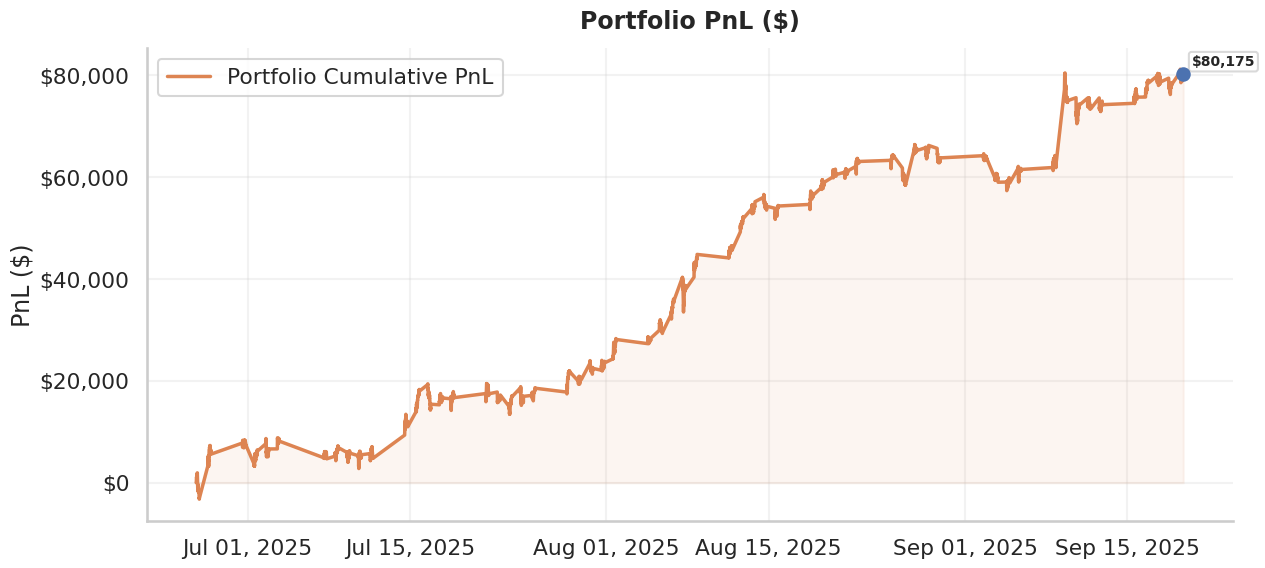

In [60]:
#Plot portfolio PnL
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter, AutoDateLocator
import matplotlib.pyplot as plt

sns.set_theme(context="talk", style="whitegrid", font_scale=0.95)
LINE_COLOR = sns.color_palette("deep")[1]

def _fmt_dollars(x, pos): return f"${x:,.0f}"
def _annotate_last_point(ax, series, fmt="${:,.0f}", xytext=(6, 6)):
    if len(series) == 0: return
    x = series.index[-1]; y = series.iloc[-1]
    ax.scatter([x], [y], s=80, zorder=5)
    ax.annotate(fmt.format(y), (x, y), xytext=xytext, textcoords="offset points",
                fontsize=10, weight="bold",
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="0.85"))

def plot_portfolio_cumpnl(portfolio_pnl: pd.Series, title="Portfolio Cumulative PnL ($)"):
    cum_pnl = portfolio_pnl.cumsum()
    fig, ax = plt.subplots(figsize=(13, 6))
    ax.plot(cum_pnl.index, cum_pnl.values, color=LINE_COLOR, linewidth=2.5, label="Portfolio Cumulative PnL")
    ax.fill_between(cum_pnl.index, cum_pnl.values, alpha=0.08, color=LINE_COLOR)
    ax.set_title(title, pad=14, weight="bold")
    ax.set_xlabel(""); ax.set_ylabel("PnL ($)")
    ax.yaxis.set_major_formatter(FuncFormatter(_fmt_dollars))
    ax.xaxis.set_major_locator(AutoDateLocator()); ax.xaxis.set_major_formatter(DateFormatter("%b %d, %Y"))
    ax.grid(True, which="major", alpha=0.25); _annotate_last_point(ax, cum_pnl)
    sns.despine(ax=ax, left=False, bottom=False); ax.legend(frameon=True)
    plt.tight_layout(); plt.show()

plot_portfolio_cumpnl(portfolio_pnl, title="Portfolio PnL ($)")
